# imports 



In [ ]:
!pip install hazm
!pip install -q clean-text[gpl]
!pip install keras-tuner

     |████████████████████████████████| 317kB 8.2MB/s 
     |████████████████████████████████| 1.4MB 27.2MB/s 
     |████████████████████████████████| 235kB 47.9MB/s 
  Created wheel for nltk: filename=nltk-3.3-cp37-none-any.whl size=1394485 sha256=0c6e94c5b7eec837778471169458cc7b35174f968ccbb6bfc027a172a806ffbb
  Stored in directory: /root/.cache/pip/wheels/d1/ab/40/3bceea46922767e42986aef7606a600538ca80de6062dc266c
  Created wheel for libwapiti: filename=libwapiti-0.2.1-cp37-cp37m-linux_x86_64.whl size=153925 sha256=6f61a82f66af0659fabedad187aaaedc0cb49bf97f8b92073890ffe59fb28da7
  Stored in directory: /root/.cache/pip/wheels/66/15/54/4510dce8bb958b1cdd2c47425cbd1e1eecc0480ac9bb1fb9ab
Successfully built nltk libwapiti
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5
     |████████████████████████████████| 133kB 11.2MB/s 
     |████████████████████████████████| 71kB 10.4MB/s 
     |████████████████████████████████| 245kB 

In [ ]:
import re
import os
import zipfile
import random
import nltk
import hazm
import requests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import kerastuner
import plotly.graph_objects as go

from google.colab import files
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from cleantext import clean

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from numpy import argmax

nltk.download('punkt')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  del sys.path[0]


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Load & Explore Data

In [ ]:
def cleaning(text):

    text = text.strip()

    text = clean(text,
        fix_unicode=True,
        to_ascii=False,
        lower=True,
        no_line_breaks=True,
        no_urls=True,
        no_emails=True,
        no_phone_numbers=True,
        no_numbers=True,
        no_digits=True,
        no_currency_symbols=True,
        no_punct=True,
        replace_with_url="",
        replace_with_email="",
        replace_with_phone_number="",
        replace_with_number="",
        replace_with_digit="0",
        replace_with_currency_symbol="")


    cleanr = re.compile('<.*?>')
    text = re.sub(cleanr, '', text)
    

    normalizer = hazm.Normalizer()
    text = normalizer.normalize(text)
    

    wierd_pattern = re.compile("["
        u"\U0001F600-\U0001F64F" 
        u"\U0001F300-\U0001F5FF"  
        u"\U0001F680-\U0001F6FF" 
        u"\U0001F1E0-\U0001F1FF"  
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u'\U00010000-\U0010ffff'
        u"\u200d"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\u3030"
        u"\ufe0f"
        u"\u2069"
        u"\u2066"
        u"\u2068"
        u"\u2067"
        "]+", flags=re.UNICODE)

    text = wierd_pattern.sub(r'', text)
    

    text = re.sub("#", "", text)
    text = re.sub("\s+", " ", text)
    text = re.sub(r"[_@%•✅●><✔️*/٪؛=«»؟\.#?!,،:;\[\](){}\'\"-]", " ", text)


    stop_words = hazm.utils.stopwords_list()
    for word in stop_words:
        token = ' ' + word + ' '
        text = text.replace(token, ' ')

    return text


def data_gl_than(data, less_than=100.0, greater_than=0.0):
    data_length = data['cleaned_description_fa_len_by_words'].values

    data_glt = sum([1 for length in data_length if greater_than < length <= less_than])

    data_glt_rate = (data_glt / len(data_length)) * 100

    print(f'cleaned_comment with word length of greater than {greater_than} and less than {less_than} includes {data_glt_rate:.2f}% of the whole!')


def print_info(data, description, greater_than, less_than ,has_label=True):

    print(f"------------------------ {description} ------------------------")
    print('\n\n\n')

    min_max_len = data["cleaned_description_fa_len_by_words"].min(), data["cleaned_description_fa_len_by_words"].max()
    fig = go.Figure()
    fig.add_trace(go.Histogram(
        x = data['cleaned_description_fa_len_by_words']
    ))
    fig.update_layout(
        title_text='Distribution of word counts within comments',
        xaxis_title_text='Word Count',
        yaxis_title_text='Frequency',
        bargap=0.2,
        bargroupgap=0.2)
    fig.show()

    print("------------------------------------------------------------\n\n")
    print(f'Min length: {min_max_len[0]} \tMax length: {min_max_len[1]}')
    print(data_gl_than(data, less_than, greater_than))
    print("\n\n------------------------------------------------------------\n\n")

    if has_label:
        fig = go.Figure()

        groupby_rate = data.groupby('label')['label'].count()

        fig.add_trace(go.Bar(
            x=list(sorted(groupby_rate.index)),
            y=groupby_rate.tolist(),
            text=groupby_rate.tolist(),
            textposition='auto'
        ))

        fig.update_layout(
            title_text='Distribution of rate within comments',
            xaxis_title_text='Rate',
            yaxis_title_text='Frequency',
            bargap=0.2,
            bargroupgap=0.2)

        fig.show()

    print(f"------------------------ {''.join(['#' for _ in range(len(description))])} ------------------------", end='\n\n\n')



def Tokenize(data, tokenizer_on_tarin=None, oov_token='<OOV>',  maxlen=256, padding='post', truncating='post'):

    if tokenizer_on_tarin is None:
        tokenizer = Tokenizer(oov_token='<OOV>')
        tokenizer.fit_on_texts(data)
    
    else:
        tokenizer = tokenizer_on_tarin

    sequence = tokenizer.texts_to_sequences(data)

    pad_sequence = pad_sequences(sequence, maxlen=maxlen, padding='post', truncating='post')

    return pad_sequence, tokenizer



def preprocess(train_dir, test_dir, test_size, grater_than, less_than, oov_token='<OOV>',  maxlen=256, padding='post', truncating='post'):

    print('Loading Train & Test from directory')

    train = pd.read_csv(train_dir)
    test = pd.read_csv(test_dir)
 


    print('\nCleaning Train description_fa from this features : ')
    print('\t1-line_breaks\n\t2-urls\n\t3-emails\n\t4-phone_numbers\n\t5-numbers\n\t6-digits\n\t7-currency_symbols\n\t8-punctuation\n\t9-HEML tags')

    train['cleaned_description_fa'] = train['description_fa'].apply(cleaning)

    print('\nCleaning Train description_fa from this features : ')
    print('\t1-line_breaks\n\t2-urls\n\t3-emails\n\t4-phone_numbers\n\t5-numbers\n\t6-digits\n\t7-currency_symbols\n\t8-punctuation\n\t9-HEML tags')

    test['cleaned_description_fa'] = test['description_fa'].apply(cleaning)
    


    print('\nadding cleaned_description_fa_len_by_words to columns of train')
    train['cleaned_description_fa_len_by_words'] = train['cleaned_description_fa'].apply(lambda t: len(hazm.word_tokenize(t)))
    print('\nadding cleaned_description_fa_len_by_words to columns of test')
    test['cleaned_description_fa_len_by_words'] = test['cleaned_description_fa'].apply(lambda t: len(hazm.word_tokenize(t)))



    print_info(data=train, 
               description='train information',
               greater_than=grater_than,
               less_than=less_than,
               has_label=True)
    
    print_info(data=test, 
               description='test information',
               greater_than=grater_than,
               less_than=less_than,
               has_label=False)



    print('\nspliting data in to train and validation')
    train, validation = train_test_split(train, test_size=test_size, random_state=1, stratify=train['label'])
    train = train.reset_index(drop=True)
    validation = validation.reset_index(drop=True)

    x_train, y_train = train['cleaned_description_fa'].values.tolist(), train['label'].values.tolist()
    x_val, y_val = validation['cleaned_description_fa'].values.tolist(), validation['label'].values.tolist()
    x_test = test['cleaned_description_fa'].values.tolist()

    print(f'number of trains {len(x_train)}')
    print(f'number of validations {len(x_val)}')
    print(f'number of tests {len(x_test)}')

    print('\nTokenizing train validation and test data')
    

    x_train, tokenizer = Tokenize(data=x_train, 
                                  tokenizer_on_tarin=None, 
                                  oov_token=oov_token, 
                                  maxlen=maxlen, 
                                  padding=padding, 
                                  truncating=truncating)
    
    x_val, _ = Tokenize(data=x_val, 
                        tokenizer_on_tarin=tokenizer, 
                        oov_token=oov_token,  
                        maxlen=maxlen, 
                        padding=padding, 
                        truncating=truncating)
    
    x_test, _ = Tokenize(data=x_test, 
                         tokenizer_on_tarin=tokenizer,
                         oov_token=oov_token,  
                         maxlen=maxlen, 
                         padding=padding, 
                         truncating=truncating)


    y_train = tf.keras.utils.to_categorical(y_train)
    y_val = tf.keras.utils.to_categorical(y_val)


    return x_train, y_train, x_val, y_val, x_test, tokenizer


In [ ]:
train_dir = os.path.join(os.getcwd(),'train_set.csv')
test_dir = os.path.join(os.getcwd(),'test_set.csv')

x_train, y_train, x_val, y_val, x_test, tokenizer  = preprocess(train_dir, 
                                                              test_dir, 
                                                              test_size=0.1, 
                                                              grater_than=3, 
                                                              less_than=250,
                                                              oov_token='<OOV>',  
                                                              maxlen=150, 
                                                              padding='post', 
                                                              truncating='post')

Loading Train & Test from directory

Cleaning Train description_fa from this features : 
	1-line_breaks
	2-urls
	3-emails
	4-phone_numbers
	5-numbers
	6-digits
	7-currency_symbols
	8-punctuation
	9-HEML tags

Cleaning Train description_fa from this features : 
	1-line_breaks
	2-urls
	3-emails
	4-phone_numbers
	5-numbers
	6-digits
	7-currency_symbols
	8-punctuation
	9-HEML tags

adding cleaned_description_fa_len_by_words to columns of train

adding cleaned_description_fa_len_by_words to columns of test
------------------------ train information ------------------------






------------------------------------------------------------


Min length: 1 	Max length: 2077
cleaned_comment with word length of greater than 3 and less than 250 includes 97.58% of the whole!
None


------------------------------------------------------------




------------------------ ################# ------------------------


------------------------ test information ------------------------






------------------------------------------------------------


Min length: 5 	Max length: 517
cleaned_comment with word length of greater than 3 and less than 250 includes 97.99% of the whole!
None


------------------------------------------------------------


------------------------ ################ ------------------------



spliting data in to train and validation
number of trains 34109
number of validations 3790
number of tests 10000

Tokenizing train validation and test data


# Classifier

In [ ]:
def download_file(url, save_to):
    if not os.path.isfile(save_to):
        try:
            r = requests.get(url)
        except requests.ConnectionError:
            print("!!! Failed to download data !!!")
        else:
            if r.status_code != requests.codes.ok:
                print("!!! Failed to download data !!!")

        with open(save_to, "wb") as fid:
            fid.write(r.content)



def pre_trained_embed(tokenizer ,*args, **kwargs):

    LOCAL_PATH = os.getcwd()
    VECTORS_PATH = kwargs['VECTORS_PATH']

    download_file(VECTORS_PATH, LOCAL_PATH + '/vectors.zip')
    zip_ref = zipfile.ZipFile(os.path.join(LOCAL_PATH, 'vectors.zip'), 'r')
    zip_ref.extractall(path=os.path.join(LOCAL_PATH, 'vectors'))
    zip_ref.close()

    vocab_size = len(tokenizer.word_index) + 1
    embeddings_dictionary = dict()

    glove_file = open(LOCAL_PATH + '/vectors/vectors.txt', encoding="utf8")

    for line in glove_file:
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary[word] = vector_dimensions
    glove_file.close()

    embedding_matrix = np.zeros((vocab_size, kwargs['numfeatures']))
    for word, index in tokenizer.word_index.items():
        embedding_vector = embeddings_dictionary.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

    return embedding_matrix, vocab_size



def bi_rnn_model(*args, **kwargs):
    
    model_input = Input(shape=kwargs['Input_shape'])

    model = Embedding(input_dim=kwargs['n_words'], 
                      output_dim=kwargs['numfeatures'],
                      weights=[kwargs['embedding_matrix']], 
                      trainable=kwargs['trainable'],
                      name='embedding_layer')(model_input)


    model = Bidirectional(LSTM(units=600,
                            dropout=0.5,
                            return_sequences=True), 
                          name='Bi_LSTM_1')(model)


    model = Bidirectional(LSTM(units=600,
                            dropout=0.5), 
                          name='Bi_LSTM_2')(model)


    model = Dense(units=200, 
                  activation='relu', 
                  name='Dense')(model)
 
    model = Dropout(rate=0.2, 
                    name='Dropout')(model)

    model = Dense(units=10, 
                  activation='softmax', 
                  name='Final_Dense')(model)

    model = Model(inputs=model_input, outputs=model)

    tf.keras.utils.plot_model(model,
                              to_file="model.png",
                              show_shapes=False,
                              show_dtype=False,
                              show_layer_names=True,
                              rankdir="TB",
                              expand_nested=False,
                              dpi=96,
                              )
    
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    loss = tf.keras.losses.CategoricalCrossentropy()
    model.compile(optimizer=opt, loss=loss, metrics = METRICS)
    
    return model


def plot_learning_curve(history, metric):
    plt.figure()
    plt.plot(history.history[metric], '-o')
    plt.plot(history.history['val_' + metric], '-o')
    plt.title(metric)
    plt.legend([metric, 'val_' + metric])
    plt.xlabel('epochs')
    plt.grid('on')
    plt.ylabel(metric)


class callback_model(tf.keras.callbacks.Callback):
    def on_epoch_end(self,arg,logs={}):
        tp = logs["val_tp"]
        fp = logs["val_fp"]
        tn = logs["val_tn"]
        fn = logs["val_fn"]

        balanced_accuracy = ((tp/(tp + fn)) +  (tn/(tn+fp)))
        print(f'balanced_accuracy = {balanced_accuracy}')


Epoch 1/10
1066/1066 [==============================] - 224s 205ms/step - loss: 1.3731 - accuracy: 0.5049 - tp: 11058.0000 - fp: 4362.0000 - tn: 302619.0000 - fn: 23051.0000 - val_loss: 1.0597 - val_accuracy: 0.6201 - val_tp: 1788.0000 - val_fp: 470.0000 - val_tn: 33640.0000 - val_fn: 2002.0000
balanced_accuracy = 1.457988859571973
Epoch 2/10
1066/1066 [==============================] - 214s 201ms/step - loss: 1.0207 - accuracy: 0.6371 - tp: 17063.0000 - fp: 4912.0000 - tn: 302069.0000 - fn: 17046.0000 - val_loss: 0.8983 - val_accuracy: 0.6810 - val_tp: 2199.0000 - val_fp: 575.0000 - val_tn: 33535.0000 - val_fn: 1591.0000
balanced_accuracy = 1.5633538551744355
Epoch 3/10
1066/1066 [==============================] - 215s 202ms/step - loss: 0.8761 - accuracy: 0.6924 - tp: 19966.0000 - fp: 5114.0000 - tn: 301867.0000 - fn: 14143.0000 - val_loss: 0.8458 - val_accuracy: 0.7063 - val_tp: 2403.0000 - val_fp: 668.0000 - val_tn: 33442.0000 - val_fn: 1387.0000
balanced_accuracy = 1.6144532395192

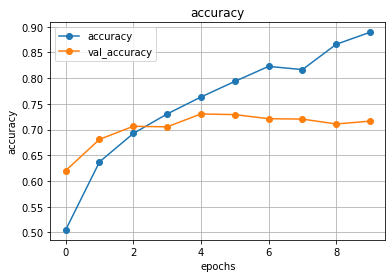

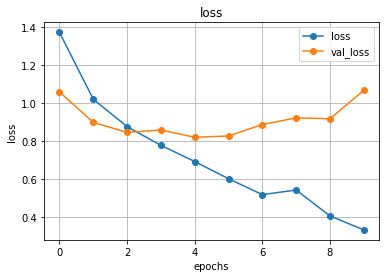

In [ ]:
GLOVE_VECTORS_PATH = 'https://github.com/Text-Mining/Persian-Wikipedia-Corpus/raw/master/models/glove/vectors.zip'

embedding_matrix, vocab_size = pre_trained_embed(tokenizer=tokenizer,
                                                 VECTORS_PATH=GLOVE_VECTORS_PATH,
                                                 numfeatures = 50)

METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn'),
]

model = bi_rnn_model(Input_shape=x_train.shape[1],
             n_words=vocab_size,
             numfeatures=50,
             embedding_matrix=embedding_matrix,
             trainable=True,
             METRICS=METRICS)


callback = callback_model()

history = model.fit(x_train, y_train, epochs=10, verbose=True, validation_data=(x_val, y_val), callbacks=callback)

plot_learning_curve(history, 'accuracy')
plot_learning_curve(history, 'loss')
plt.show()

In [ ]:
predicted = model.predict(x_test, verbose=1)

In [ ]:
df['predicted'] = np.argmax(predicted.get('logits'), axis=-1)
df[['app_id', 'predicted']].to_csv('prediction.csv', sep=',',index=False)
df.head()